## Notes
- [ ] high sample weights for false negatives
- [ ] similarly, give weights based on the variation frequencies of each loci
- [ ] keep careful track of all the decisions we are making in the different methods we are trying
- [ ] consider semi-supervised methods if we find public sequences online for staph and pseudomonas (which will be unlabeled sequences)
- [ ] build pipeline module
- [ ] investigate other machine learning papers done on staph and pseudomonas

# Explore data

In [3]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dendropy
import Bio
from Bio import SeqIO, Phylo

from load import load_pseudo
import phylo

%matplotlib inline
pd.options.display.precision = 3
pd.options.display.max_colwidth = 10

records = load_pseudo()

In [4]:
records

,id,sequence,missing,missing_%,sequence_i,missing_i,missing_%_i,carb,toby
0,TA151,ATGAGT...,31842,6.588,ATGAGT...,28410,5.878,True,False
1,IC1,ATGAGT...,46071,9.532,ATGAGT...,34714,7.182,False,False
2,A237,ATGAGT...,44514,9.210,ATGAGT...,35933,7.434,True,False
3,5920,ATGAGT...,49497,10.241,ATGAGT...,36873,7.629,NaN,NaN
4,LiA96,ATGAGT...,44067,9.117,ATGAGT...,34454,7.128,False,False
...,...,...,...,...,...,...,...,...,...
117,JD318,------...,77766,16.090,ATGAGT...,39108,8.091,False,False
118,Jp238,------...,43062,8.909,ATGAGT...,32466,6.717,False,False
119,Jp1303,------...,44151,9.135,ATGAGT...,32792,6.785,False,False
120,JD304,------...,75465,15.613,ATGAGT...,38729,8.013,False,False


In [2]:
# calculate true/false percentage of two classes
counts_carb = records['carb'].value_counts()
counts_toby = records['toby'].value_counts()
counts = pd.DataFrame({'carb':counts_carb, 'toby':counts_toby})
counts.div(counts.sum() / 100)

,carb,toby
False,78.992,94.958
True,21.008,5.042


In [3]:
# turn whole sequence into data frame
%time sequence = pd.DataFrame.from_dict(records['sequence'].apply(list).to_dict()).transpose()

CPU times: user 32.2 s, sys: 1.3 s, total: 33.5 s
Wall time: 30.8 s


In [122]:
sequence.shape[1]/5000

96.6666

In [113]:
def count_site(sequence):
    c = pd.DataFrame(index=['A', 'C', 'G', 'T', '-'])

    for label, content in sequence.iteritems():
        if label % 1000 == 0:
            print(label / sequence.shape[1] * 100)
        c = c.join(content.value_counts(), how='outer')
    c.fillna(0, inplace=True)
    return c

In [114]:
%time c = count_site(sequence.iloc[:, :2000])

0.0
50.0
CPU times: user 3min 43s, sys: 768 ms, total: 3min 43s
Wall time: 3min 43s


In [115]:
%time s = c.cumsum()

CPU times: user 2.21 ms, sys: 1 ms, total: 3.21 ms
Wall time: 2.25 ms


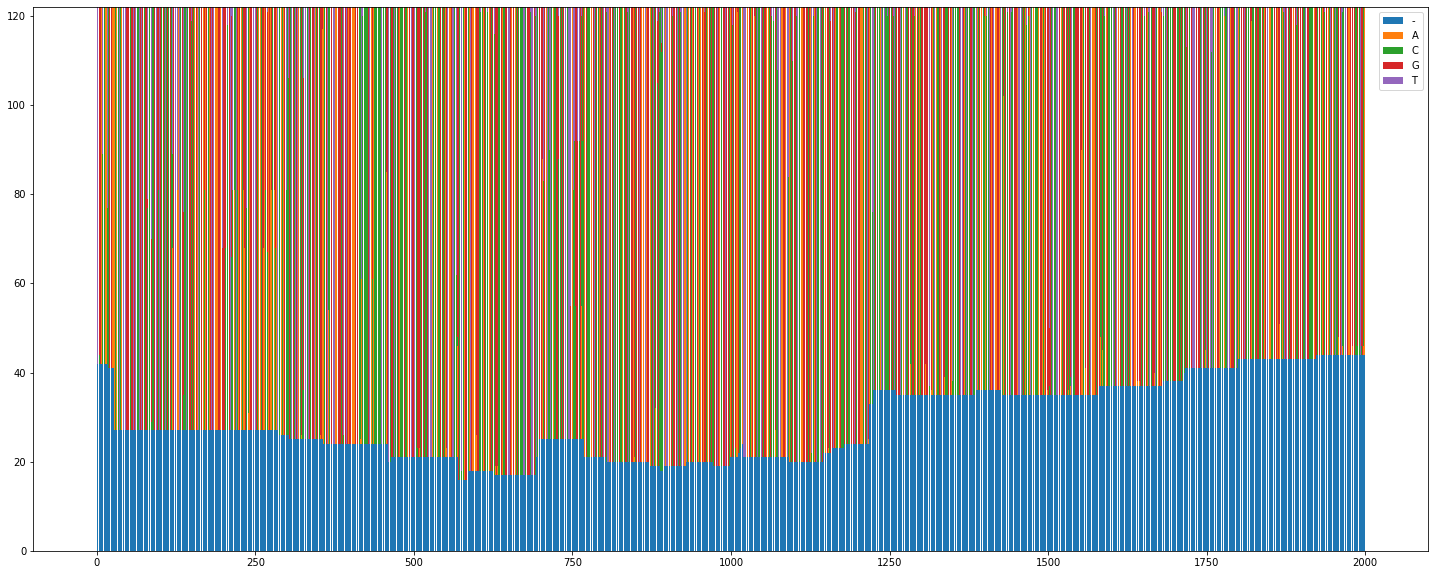

In [118]:
plt.figure(figsize=(25, 10))
x = s.shape[1]
rows = s.iterrows()
row = next(rows)
plt.bar(range(x), row[1], label=row[0])
for i, r in rows:
    plt.bar(range(x), r-row[1], bottom=row[1] ,label=i)
    row = (i, r)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [19]:
def impute(column, missing_value):
    counts = column.value_counts()
    return column.where(column != missing_value, counts.idxmax())

In [23]:
# write this out as fasta
# some column still have missingness, like 2307...
sequence_imputed = sequence.apply(lambda column: column.where(column!='-', column.value_counts().idxmax()))

,0,1,2,3,4,5,6,7,8,9,...,483323,483324,483325,483326,483327,483328,483329,483330,483331,483332
0,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
1,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
2,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
3,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
4,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
118,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
119,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A
120,A,T,G,A,G,T,G,A,T,C,...,G,C,T,G,G,A,A,T,G,A


In [52]:
with open("../data/pseudo/concatenated_naive_impute.fasta", "w") as output:
    for idx, row in sequence_imputed.iterrows():
        seq = Bio.Seq.Seq(''.join(row), alphabet=Bio.Alphabet.Alphabet())
        record = Bio.SeqRecord.SeqRecord(seq, id=records['id'][idx], description='')
        SeqIO.write(record, output, "fasta")

In [3]:
src = SeqIO.parse('../data/pseudo/concatenated_naive_impute.fasta', 'fasta')
data = [(records_pseudo.id, records_pseudo.seq._data) for records_pseudo in src]
records_imputed = pd.DataFrame(data=data, columns=['id', 'sequence'])

In [5]:
%time sequence_imputed = pd.DataFrame.from_dict(records_imputed['sequence'].apply(list).to_dict()).transpose()

CPU times: user 30.9 s, sys: 2.02 s, total: 32.9 s
Wall time: 25.9 s


In [123]:
%time c_imputed = count_site(sequence_imputed.iloc[:, :2000])

0.0
50.0
CPU times: user 3min 45s, sys: 1.01 s, total: 3min 46s
Wall time: 3min 46s


In [126]:
%time s_imputed = c_imputed.cumsum()

CPU times: user 2.59 ms, sys: 2 ms, total: 4.6 ms
Wall time: 3.32 ms


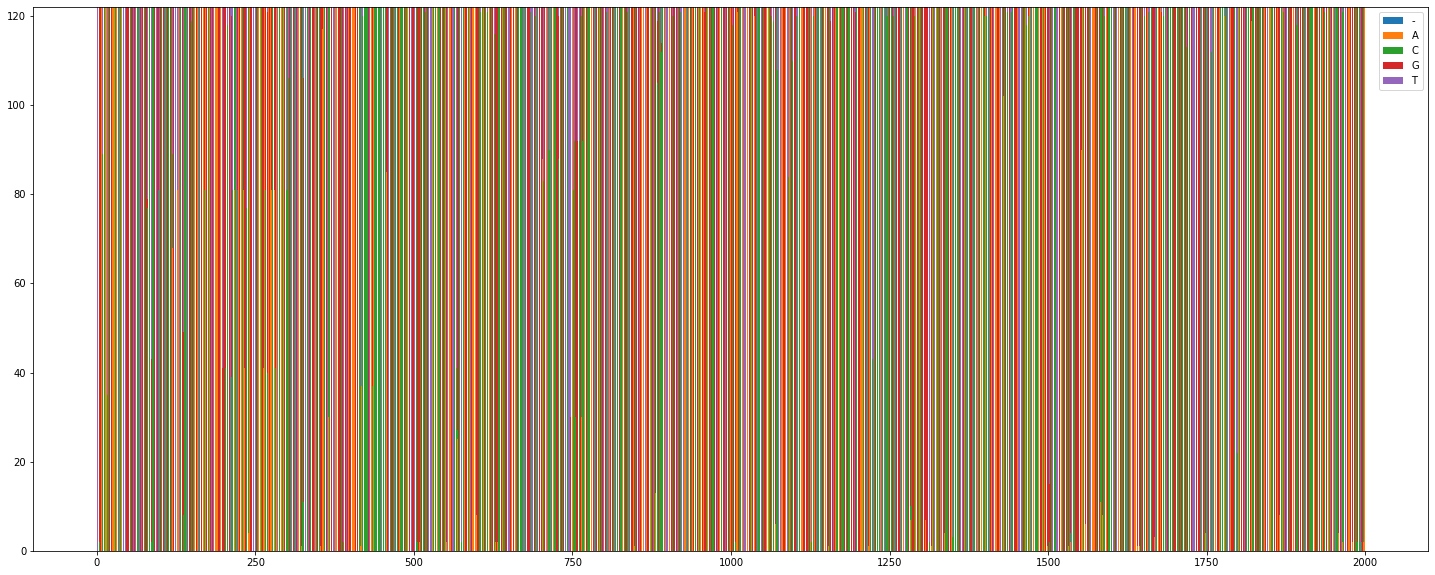

In [127]:
plt.figure(figsize=(25, 10))
x = s_imputed.shape[1]
rows = s_imputed.iterrows()
row = next(rows)
plt.bar(range(x), row[1], label=row[0])
for i, r in rows:
    plt.bar(range(x), r-row[1], bottom=row[1] ,label=i)
    row = (i, r)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Group into condons

In [53]:
# group genes in the sequence by three (into condons)
# and count different number of condons across all samples
condonify = lambda seq: [seq[i:i+3] for i in range(0, len(seq), 3)]
sequence_condonified = records['sequence'].apply(condonify)
c = Counter()
for condons in sequence_condonified:
    c.update(Counter(condons))

In [57]:
pd.DataFrame(sequence_condonified.to_dict()).transpose()

,0,1,2,3,4,5,6,7,8,9,...,161101,161102,161103,161104,161105,161106,161107,161108,161109,161110
0,ATG,AGT,GAT,CTG,CCA,AGT,CCG,AAG,AAA,CAC,...,---,---,---,---,---,---,---,---,---,---
1,ATG,AGT,GAT,CTG,CCA,AGT,CCG,AAG,AAA,CAC,...,GTG,GTC,ACC,ACC,GAC,GAG,GTG,CTG,GAA,TGA
2,ATG,AGT,GAT,CTG,CCA,AGT,CCG,AAG,AAA,CAC,...,GTG,GTC,ACC,ACC,GAC,GAG,GTG,CTG,GAA,TGA
3,ATG,AGT,GAT,CTG,CCA,AGT,CCG,AAG,AAA,CAC,...,GTG,GTC,ACC,ACC,GAC,GAG,GTG,CTG,GAA,TGA
4,ATG,AGT,GAT,CTG,CCA,AGT,CCG,AAG,AAA,CAC,...,GTG,GTC,ACC,ACC,GAC,GAG,GTG,CTG,GAA,TGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,---,---,---,---,---,---,---,---,---,---,...,GTG,GTC,ACC,ACC,GAC,GAG,GTG,CTG,GAA,TGA
118,---,---,---,---,---,---,---,---,---,---,...,GTG,GTC,ACC,ACC,GAC,GAG,GTG,CTG,GAA,TGA
119,---,---,---,---,---,---,---,---,---,---,...,GTG,GTC,ACC,ACC,GAT,GAG,GTG,CTG,GAA,TGA
120,---,---,---,---,---,---,---,---,---,---,...,GTG,GTC,ACC,ACC,GAC,GAG,GTG,CTG,GAA,TGA


In [ ]:
len(c.keys())

In [ ]:
c.keys()

In [ ]:
# verify the result
sum(c.values()) * 3 / 122 == seq_len

In [ ]:
%time condon_df = pd.DataFrame(sequence_condonified.to_list())

## no imputation

In [ ]:
l = []
for i in range(condon_df.shape[1]):
    if condon_df.iloc[:, i].value_counts().size == 1:
        l.append(i)

In [ ]:
condon_df_variant = condon_df.drop(columns=l)
condon_df_variant.shape

## naive imputation

In [ ]:
def impute(condons):
    '''replace --- with the most frequent condon at this locus'''
    counts = condons.value_counts()
    if '---' in counts.index:
        return condons.where(condons!='---', counts.idxmax())
    return condons

In [ ]:
%time condon_df_impute = condon_df.apply(impute)

In [ ]:
l_impute = []
for i in range(condon_df_impute.shape[1]):
    if condon_df_impute.iloc[:, i].value_counts().size == 1:
        l_impute.append(i)

In [ ]:
condon_df_impute_variant = condon_df_impute.drop(columns=l_impute)
condon_df_impute_variant.shape

In [ ]:
c = []
for col in condon_df_impute_variant.columns:
    c.append(condon_df_impute_variant[col].value_counts().size)
condon_counts = np.bincount(c)

In [ ]:
# number of different condons at each loci
plt.bar(np.arange(condon_counts.size), condon_counts)
plt.xlim((0, 15))
plt.xlabel('different condons at a particular locus')
plt.ylabel('counts of different condons')

In [ ]:
# condon_df_impute_variant['missing'] = condon_df_impute_variant.agg()
missing = []
count_missing = lambda series: Counter(''.join(series))['-']
for row in range(condon_df_impute_variant.shape[0]):
    missing.append(count_missing(condon_df_impute_variant.iloc[row]))

In [ ]:
missing[:5]

In [ ]:
len(''.join(condon_df_impute_variant.iloc[1])), count_missing(''.join(condon_df_impute_variant.iloc[1]))

In [ ]:
seq_len_variant = condon_df_impute_variant.columns.size * 3
missing_percent = np.array(missing) / seq_len_variant * 100
plt.hist(missing_percent, bins=25)

# Distance matrix & Phylogenetic tree

In [ ]:
phylo.dist_mat(records)
dist_mat.to_csv('../data/pseudo/pseudo_dist_mat.csv')

In [3]:
dist_mat = pd.read_csv('../data/pseudo/pseudo_dist_mat.csv', index_col='id')
dist_mat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, TA151 to LiA131
Columns: 122 entries, TA151 to LiA131
dtypes: float64(122)
memory usage: 117.2+ KB


In [5]:
# create the tree
%time tree_str = phylo.upgma(dist_mat)
with open('../data/pseudo_tree.nwk', 'w') as nwk:
    nwk.write(tree_str)
tree_str

CPU times: user 1.83 s, sys: 3 µs, total: 1.83 s
Wall time: 1.83 s


'(((((((((TA151,(((Jp222,(Bo559,W15Apr4)),Cotonu1),LiA179)),((((Lw1047,CPHL2000),(((LiA18,Jp241),A17),Aa249)),LiA145),(((A15,A9),Tu863),(Tu61,SWPA15J_NSWPA15a)))),((ATCC27853,((LiA50,(A22,(W15Aug23,Us411))),(M72,((A11,A13),(5BR2,CPHL10299))))),PhDW6)),(((((IC1,((CPHL950,Mi159),W5Aug16)),Pae85),((ESP06B,Br993),(Co380791,Co398373))),(((((A237,Pae113),(W15Okt31,Jp245)),(((C3128,PT31M),W5Aug28),(C5311,JD303))),LiA161),(A19,((((Pae110,Pae100),Pae102),CPHL8203),CPHL5083)))),(((((LiA96,LiA91),LiA131),PMM38),Mex2),((W15Dec3,CND03),Jp1303)))),((((((5920,(PHLS08959,W15Dec4)),(((A10,CPHL6749),Jp238),Pae160)),(Lo049,(CPHL1999,CPHL8058))),CPHL10701),(LiA70,Br670)),(((((Jp1170,Jp1200),(Jp1155,Jp1206)),TuD199),Jp224),LMG2107))),((CPHL10662,(Jp100,Jp97)),(J80UH1OS1,LiA133))),((((CN573_PSE143,(((Jp54,Jp60),J9UH1F),(W15Dec14,LiA63))),(PAO1,IDEXXCanine4)),LiA19),IDEXXCanine8)),((((JD312,JD317),(((((((JD310,JD326),JD329),JD315),JD322),JD335),JD324),JD304)),((((((JD332,JD323),JD314),(JD328,(JD316,(JD333,JD

In [2]:
with open('../data/pseudo/pseudo_tree.nwk', 'r') as nwk:
    tree_str = nwk.read()

In [13]:
# visualize tree with dendropy
tree = dendropy.Tree.get(data=tree_str, schema='newick')
print(tree.as_ascii_plot())

                                       /---------------------- TA151           
                                       |                                       
                                       |             /-------- Jp222           
                               /-------+        /----+                         
                               |       |        |    |   /---- Bo559           
                               |       |    /---+    \---+                     
                               |       |    |   |        \---- W15Apr4         
                               |       \----+   |                              
                               |            |   \------------- Cotonu1         
                               |            |                                  
                               |            \----------------- LiA179          
                               |                                               
                               |        

In [14]:
# format the ascii tree with labels
tree_ascii = tree.as_ascii_plot()
for i, record in records.iterrows():
    l = len(record['id'])
    if l < 8:
        indent = '\t\t\t'
    elif l < 13:
        indent = '\t\t'
    else:
        indent = '\t'
    tree_ascii = tree_ascii.replace(record['id'].replace('_', ' '),
                                    '{id__}:{indent}{carb}/{toby}'.format(
                                        id__=record['id'].lower(), # lower case to avoid something wrong
                                        indent=indent,carb=record['carb'],toby=record['toby']),
                                    1)
print(tree_ascii)

                                       /---------------------- ta151:			True/False           
                                       |                                       
                                       |             /-------- jp222:			False/False           
                               /-------+        /----+                         
                               |       |        |    |   /---- bo559:			False/False           
                               |       |    /---+    \---+                     
                               |       |    |   |        \---- w15apr4:			False/False         
                               |       \----+   |                              
                               |            |   \------------- cotonu1:			False/False         
                               |            |                                  
                               |            \----------------- lia179:			False/False          
                               

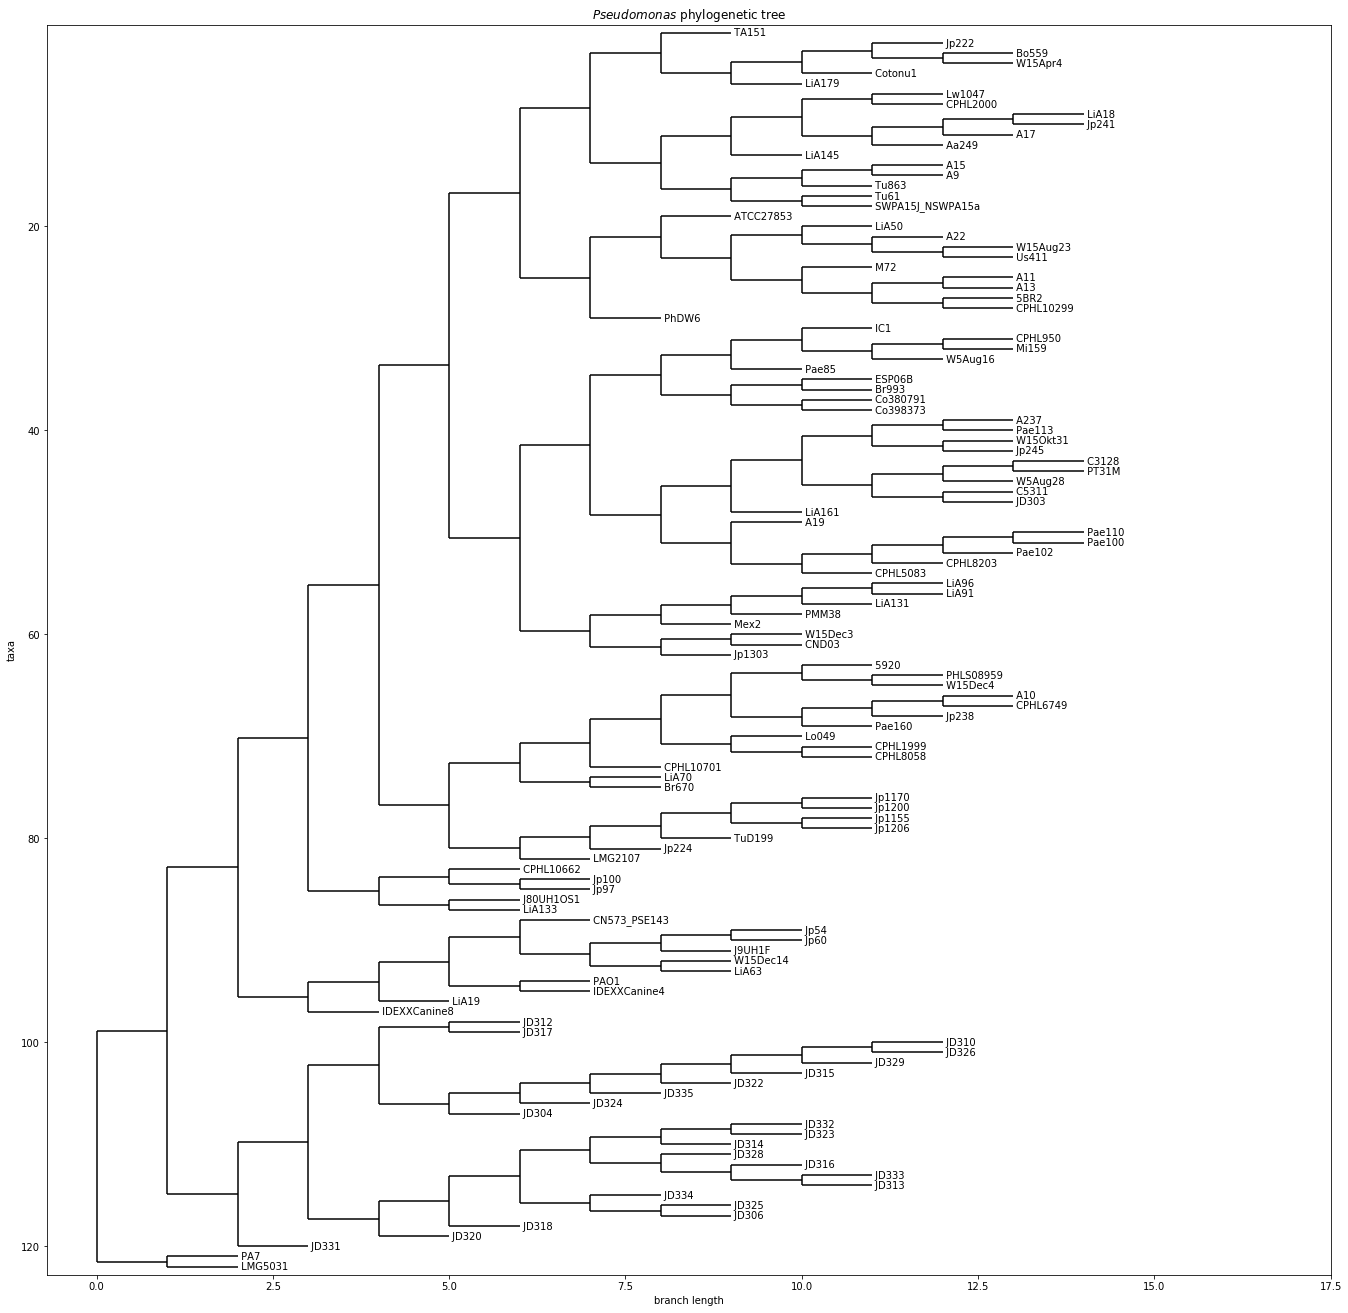

In [3]:
# visualize tree with biopython and matplotlib
phylo.draw_tree('../data/pseudo/pseudo_tree.nwk', '$Pseudomonas$ phylogenetic tree')

# Dimensionality reduction on distance matrix

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
dist_mat = pd.read_csv('../data/pseudo_dist_mat.csv', index_col='id')
dist_mat[dist_mat==np.inf] = 0

In [ ]:
scaler = StandardScaler()
dist_mat_scaled = scaler.fit_transform(dist_mat)

In [ ]:
pca = PCA(n_components=2)
dist_mat_pca = pca.fit_transform(dist_mat_scaled)

In [ ]:
plt.figure(figsize=(9.6, 4.8))
plt.subplot('121')
plt.scatter(dist_mat_pca[:, 0], dist_mat_pca[:, 1], c=records['carb'])
plt.subplot('122')
plt.scatter(dist_mat_pca[:, 0], dist_mat_pca[:, 1], c=records['toby'])

plt.tight_layout()
plt.show()

In [ ]:
tsne = TSNE(n_components=2)
dist_mat_tsne = tsne.fit_transform(dist_mat_scaled)

In [ ]:
plt.figure(figsize=(9.6, 4.8))
plt.subplot('121')
plt.scatter(dist_mat_tsne[:, 0], dist_mat_tsne[:, 1], c=records['carb'])
plt.subplot('122')
plt.scatter(dist_mat_tsne[:, 0], dist_mat_tsne[:, 1], c=records['toby'])

plt.tight_layout()
plt.show()

# Experiment

## remove redundant feature

In [14]:
records.dropna(inplace=True)

In [4]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

In [5]:
forward = str.maketrans('-ACTG', '01234')
def transformation(str):
    return [int(i) for i in str.translate(forward)]

In [6]:
encoding = records['sequence'].apply(transformation)

In [7]:
encoding = pd.DataFrame(encoding.to_dict()).transpose().to_numpy()

In [19]:
%time encoding_trans = selector.fit_transform(encoding)

CPU times: user 847 ms, sys: 457 ms, total: 1.3 s
Wall time: 1.3 s


In [20]:
encoding_trans.shape

(119, 261677)

## encoding

In [21]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')

In [22]:
encoding_seq = encoder.fit_transform(encoding_trans)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
encoding_seq_svd = svd.fit_transform(encoding_seq)

In [ ]:
plt.figure(figsize=(9.6, 4.8))
plt.subplot('121')
plt.scatter(encoding_seq_svd[:, 0], encoding_seq_svd[:, 1], c=records['carb'])
plt.subplot('122')
plt.scatter(encoding_seq_svd[:, 0], encoding_seq_svd[:, 1], c=records['toby'])

plt.tight_layout()
plt.show()

# Training

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X  = encoding_seq.todense()
y1, y2 = records['carb'].astype(int), records['toby'].astype(int)

In [32]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, stratify=y2)

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100)

In [34]:
rf_clf.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y1_test, rf_clf.predict(X1_test))

array([[23,  1],
       [ 4,  2]])

In [37]:
rf_clf.fit(X2_train, y2_train)
confusion_matrix(y2_test, rf_clf.predict(X2_test))

array([[28,  0],
       [ 2,  0]])

In [38]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')

In [39]:
lr.fit(X1_train, y1_train)
confusion_matrix(y1_test, lr.predict(X1_test))

array([[23,  1],
       [ 4,  2]])

In [40]:
lr.fit(X2_train, y2_train)
confusion_matrix(y2_test, lr.predict(X2_test))

array([[28,  0],
       [ 2,  0]])

In [49]:
y1_train.astype(int).value_counts()

0    70
1    19
Name: carb, dtype: int64

In [50]:
y1_test.astype(int).value_counts()

0    24
1     6
Name: carb, dtype: int64

In [51]:
y2_train.astype(int).value_counts()

0    85
1     4
Name: toby, dtype: int64

In [52]:
y2_test.astype(int).value_counts()

0    28
1     2
Name: toby, dtype: int64